# Load data

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [3]:
cat_cols = [x for x in train.columns if x.startswith('cat')]
cat_cols

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'cat10',
 'cat11',
 'cat12',
 'cat13',
 'cat14',
 'cat15',
 'cat16',
 'cat17',
 'cat18']

In [4]:
x_train = train.drop(columns=['id','target'])
y_train = train['target']

In [5]:
from categorical_transform import CategoricalTransform
ct = CategoricalTransform(cat_cols)
x_train = ct.fit_transform(x_train)
x_test = ct.transform(test)

# Train model

In [6]:
from flaml import AutoML
automl = AutoML()

In [8]:
automl.fit(x_train, y_train, task="classification", estimator_list=["lgbm"], 
           time_budget=60*60*5, metric='roc_auc', eval_method='cv', n_splits = 5, n_jobs=-2,
          log_file_name='flaml_lightgbm.log')

[flaml.automl: 03-08 13:48:49] {853} INFO - Evaluation method: cv
[flaml.automl: 03-08 13:48:49] {573} INFO - Using StratifiedKFold
[flaml.automl: 03-08 13:48:49] {874} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 03-08 13:48:49] {893} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 03-08 13:48:49] {953} INFO - iteration 0  current learner lgbm
[flaml.automl: 03-08 13:48:57] {1101} INFO -  at 9.0s,	best lgbm's error=0.1715,	best lgbm's error=0.1715
[flaml.automl: 03-08 13:48:57] {953} INFO - iteration 1  current learner lgbm
[flaml.automl: 03-08 13:49:03] {1101} INFO -  at 14.6s,	best lgbm's error=0.1715,	best lgbm's error=0.1715
[flaml.automl: 03-08 13:49:03] {953} INFO - iteration 2  current learner lgbm
[flaml.automl: 03-08 13:49:11] {1101} INFO -  at 23.0s,	best lgbm's error=0.1431,	best lgbm's error=0.1431
[flaml.automl: 03-08 13:49:11] {953} INFO - iteration 3  current learner lgbm
[flaml.automl: 03-08 13:49:17] {1101} INFO -  at 28.9s,	best lgbm's e

[flaml.automl: 03-08 18:37:57] {1101} INFO -  at 17348.6s,	best lgbm's error=0.1056,	best lgbm's error=0.1056
[flaml.automl: 03-08 18:37:57] {953} INFO - iteration 43  current learner lgbm
[flaml.automl: 03-08 18:40:40] {1101} INFO -  at 17512.2s,	best lgbm's error=0.1056,	best lgbm's error=0.1056
[flaml.automl: 03-08 18:40:40] {953} INFO - iteration 44  current learner lgbm
[flaml.automl: 03-08 18:47:38] {1101} INFO -  at 17930.0s,	best lgbm's error=0.1056,	best lgbm's error=0.1056
[flaml.automl: 03-08 18:47:38] {1148} INFO - selected model: LGBMClassifier(colsample_bytree=0.7837120584348249, learning_rate=0.01,
               max_bin=1023, min_child_weight=20.0, n_estimators=856, n_jobs=-2,
               num_leaves=198, objective='binary', reg_alpha=1e-10,
               reg_lambda=1.0, subsample=0.9676701147355194)
[flaml.automl: 03-08 18:47:38] {908} INFO - fit succeeded


In [9]:
1-automl.best_loss

0.8943780277112133

In [10]:
pred = automl.model.predict_proba(x_test.drop(columns='id'))[:,1]

In [11]:
submission = pd.DataFrame({'id':test['id'], 'target':pred})

In [12]:
submission.to_csv('submission_lightgbm_flaml.csv', index=False)

## Log

In [24]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename = 'flaml_lightgbm.log', time_budget = 5*60*60)

df_plot = pd.DataFrame({'time':time_history, 'loss':best_valid_loss_history})
df_plot['auc'] = 1-df_plot['loss']
df_plot['time'] = pd.to_timedelta(df_plot['time'],unit='s')

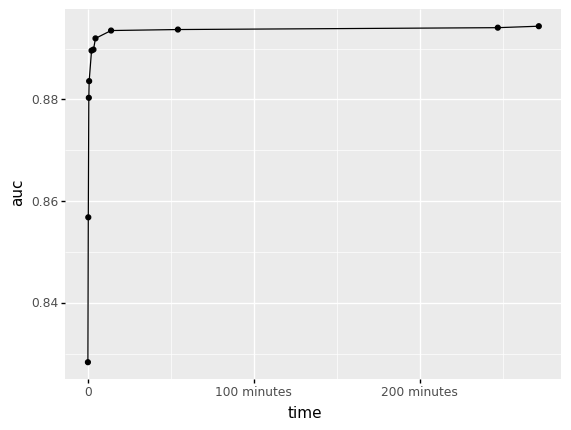

<ggplot: (8775937604136)>

In [25]:
from plotnine import ggplot, geom_point, aes, geom_line
ggplot(df_plot, aes(x='time', y='auc'))+geom_point()+geom_line()